In [135]:
#import libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import networkx as nx
import re


## Commits and contributors

### Data Cleaning & Processing

In [136]:
#read raw.txt file
rawCommit = pd.read_json("Raw/Commit/raw.txt") 
type(rawCommit)

pandas.core.frame.DataFrame

In [137]:
#split the data in 'commit' column
formatedCommit = pd.json_normalize(rawCommit.commit)
#clear useless data
formatedCommit = formatedCommit.filter(['author.name', 'committer.date'])
#format committer date into date format
formatedCommit['committer.date'] = pd.to_datetime(formatedCommit['committer.date'].str.slice(0, 10))
#sort by date
formatedCommit = formatedCommit.sort_values(by = 'committer.date')
#export to csv file
formatedCommit.to_csv('Data/Commit/clearedFile.csv', index = False)
#print the result
formatedCommit.set_index('author.name', inplace = True)

### Commits

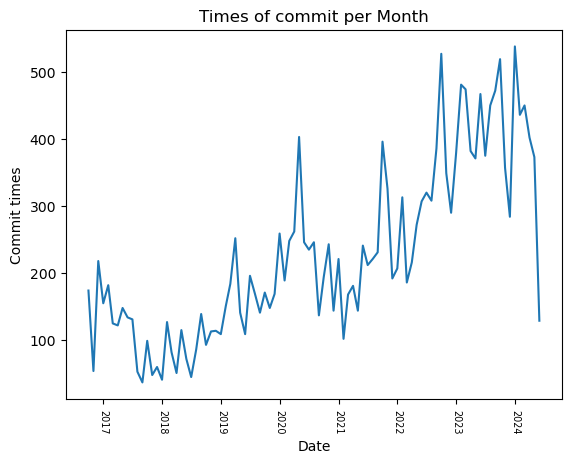

In [138]:
#Times of commit per day
date = formatedCommit.copy()
date['committer.month'] = date['committer.date'].apply(lambda x: x.strftime('%Y-%m')) 
date = date['committer.month'].groupby(pd.to_datetime(date['committer.month'])).count()
plt.plot(date.index, date.values)
plt.xlabel('Date')
plt.ylabel('Commit times')
plt.title('Times of commit per Month')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=270, fontweight='light',  fontsize='x-small')
plt.show()

### Contributors

                    committer.date
author.name                       
0xADADA                          1
Oriol Collell                    1
Orri Arnarsson                   1
Orta                             1
Orta Therox                      1
...                            ...
vercel-release-bot             763
Jiachi Liu                     838
Joe Haddad                    1239
Tim Neutkens                  2397
JJ Kasper                     2873

[3386 rows x 1 columns]


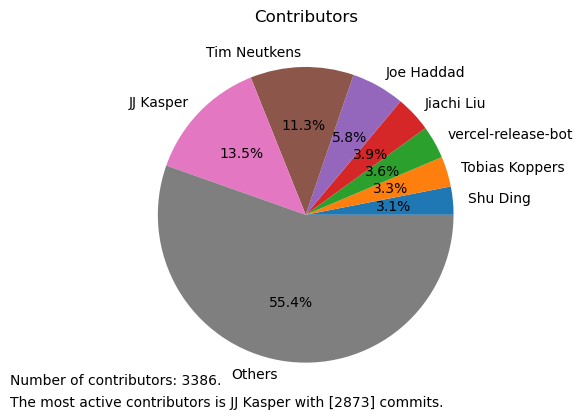

In [139]:
#Contributor
contri = formatedCommit.pivot_table(index = 'author.name', values = 'committer.date', aggfunc = 'count')
contri = contri.sort_values(by='committer.date')
print(contri)
contri2 = contri[-7:].copy()
contri2.loc['Others'] = contri[:-7].sum()
plt.text(-2, -1.15, f'Number of contributors: {len(contri)}.')
plt.text(-2, -1.3, f'The most active contributors is {contri.index[-1]} with {contri.values[-1]} commits.')
plt.pie(contri2['committer.date'], labels=contri2.index, autopct='%1.1f%%')
plt.title('Contributors')
plt.show()

/tmp/ipykernel_4724/4291759176.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(-3, -950, f'Longest contributor time: {top20Contri.index[-1]} with {top20Contri["time"][-1]} days.')


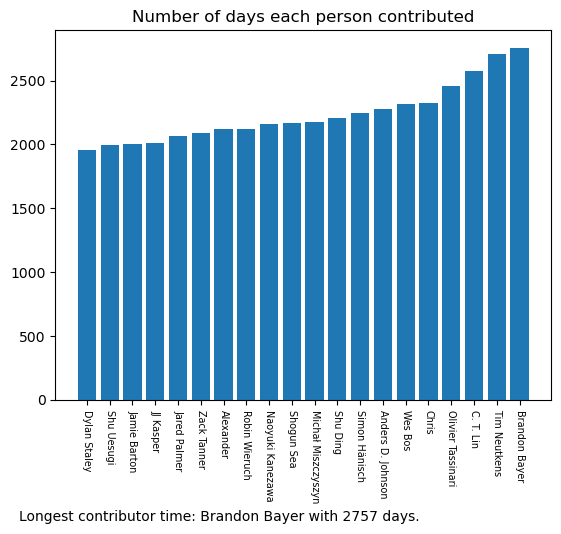

In [140]:
contriTime = formatedCommit.sort_values(by = ['author.name', 'committer.date'], ascending = [True, True])[[ 'committer.date']]
firstContri = contriTime[~contriTime.index.duplicated(keep='first')]
lastContri = contriTime[~contriTime.index.duplicated(keep='last')]
contriTime = pd.merge(firstContri, lastContri, right_index=True, left_index=True, suffixes=('_first', '_last'))
contriTime['time'] = (contriTime['committer.date_last'] - contriTime['committer.date_first']).dt.days +1
contriTime = contriTime.sort_values(by = 'time')
top20Contri = contriTime[-20:].copy()
plt.subplot().bar(x = top20Contri.index, height = top20Contri['time'])
plt.xticks(rotation=270, fontweight='light',  fontsize='x-small')
plt.title("Number of days each person contributed")
plt.text(-3, -950, f'Longest contributor time: {top20Contri.index[-1]} with {top20Contri["time"][-1]} days.')
plt.show()

/tmp/ipykernel_4724/2049783655.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  freq30daysmore = freq[contriTime['time'] > 2000]
/tmp/ipykernel_4724/2049783655.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(-5, -0.5, f'Most frequency contributor: {freq30daysmore.index[-1]} with {freq30daysmore["freq"][-1]:.2f} commits/day.')


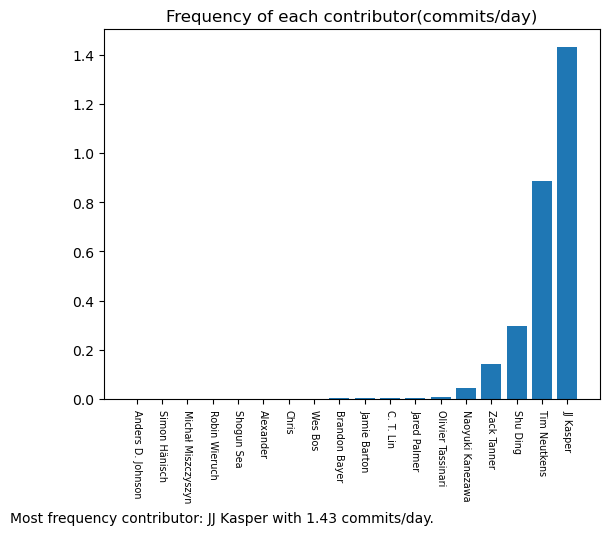

In [141]:
freq = pd.merge(contri, contriTime, on='author.name', suffixes=('_contr', '_time'))
freq["freq"] = freq["committer.date"] / freq["time"]
freq.to_csv('Data/Commit/finalFile.csv', index = False)
freq30daysmore = freq[contriTime['time'] > 2000]
freq30daysmore = freq30daysmore.sort_values(by = 'freq')
plt.subplot().bar(x = freq30daysmore.index, height = freq30daysmore['freq'])
plt.xticks(rotation=270, fontweight='light',  fontsize='x-small')
plt.title("Frequency of each contributor(commits/day)")
plt.text(-5, -0.5, f'Most frequency contributor: {freq30daysmore.index[-1]} with {freq30daysmore["freq"][-1]:.2f} commits/day.')
plt.show()

## Issues

### Data Cleaning & Processing

In [142]:
#read raw.txt file
rawIssue = pd.read_json("Raw/Issue/raw.txt") 
formatedIssue = rawIssue[['title', 'created_at', 'closed_at']]
formatedIssue['created_at'] = pd.to_datetime(formatedIssue['created_at'].astype(str).str.slice(0, 10))
formatedIssue['closed_at'] = pd.to_datetime(formatedIssue['closed_at'].astype(str).str.slice(0, 10))
formatedIssue.set_index('title', inplace = True)
formatedIssue = formatedIssue.sort_values(by = 'created_at')
formatedIssue.to_csv('Data/Issue/clearedFile.csv', index = False)

/tmp/ipykernel_4724/3497243696.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  formatedIssue['created_at'] = pd.to_datetime(formatedIssue['created_at'].astype(str).str.slice(0, 10))
/tmp/ipykernel_4724/3497243696.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  formatedIssue['closed_at'] = pd.to_datetime(formatedIssue['closed_at'].astype(str).str.slice(0, 10))


### Issues

/tmp/ipykernel_4724/1099572945.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  timeSolve['timeSolve'][0] = formatedIssue[formatedIssue['timeSolve'] == 0]['timeSolve'].count()
/tmp/ipykernel_4724/1099572945.py:5: FutureWarning: Series.__s

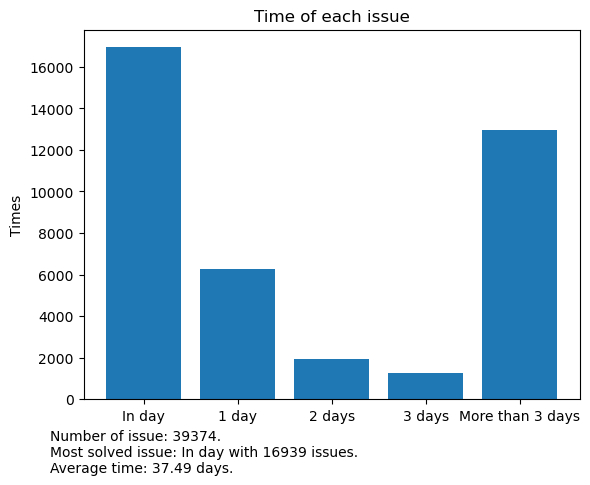

In [143]:
formatedIssue['timeSolve'] = (formatedIssue['closed_at'] - formatedIssue['created_at']).dt.days
timeSolve = pd.DataFrame()
timeSolve.index = ['In day', '1 day', '2 days', '3 days', 'More than 3 days']
timeSolve['timeSolve'] = [formatedIssue[formatedIssue['timeSolve'] == 0].count(), 0, 0, 0, 0]
timeSolve['timeSolve'][0] = formatedIssue[formatedIssue['timeSolve'] == 0]['timeSolve'].count() 
timeSolve['timeSolve'][1] = formatedIssue[formatedIssue['timeSolve'] == 1]['timeSolve'].count()
timeSolve['timeSolve'][2] = formatedIssue[formatedIssue['timeSolve'] == 2]['timeSolve'].count()
timeSolve['timeSolve'][3] = formatedIssue[formatedIssue['timeSolve'] == 3]['timeSolve'].count()
timeSolve['timeSolve'][4] = formatedIssue[formatedIssue['timeSolve'] > 3]['timeSolve'].count()
plt.subplot().bar(x = timeSolve.index, height = timeSolve['timeSolve'])
plt.ylabel('Times')
plt.title('Time of each issue')
plt.text(-1, -2000, f'Number of issue: {len(formatedIssue)}.')
plt.text(-1, -2750, f'Most solved issue: {timeSolve["timeSolve"].idxmax()} with {timeSolve["timeSolve"].max()} issues.')
plt.text(-1, -3500, f'Average time: {formatedIssue["timeSolve"].mean():.2f} days.')
formatedIssue.to_csv('Data/Issue/finalFile.csv', index = False)

## Pull requests

### Data Cleaning & Processing

In [144]:
#read raw.txt file
rawPull = pd.read_json("Raw/Pull/raw.txt") 
# rawPull.to_csv('Data/Pull/clearedFile.csv', index = False)
formatedPull = rawPull.filter(['title', 'created_at', 'merged_at'])
formatedPull.set_index('title', inplace = True)
formatedPull.to_csv('Data/Pull/clearedFile.csv', index = False)

/tmp/ipykernel_4724/3391575954.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  totalPullRequest['merged'][0] = formatedPull[formatedPull['merged'] == True]['merged'].count()
/tmp/ipykernel_4724/3391575954.py:6: FutureWarning: Series.__se

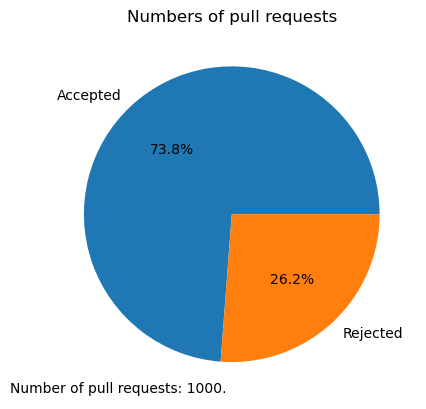

In [145]:
formatedPull.columns
formatedPull['merged'] = formatedPull['merged_at'].notna()
totalPullRequest = pd.DataFrame()
totalPullRequest.index = ['Accepted', 'Rejected']
totalPullRequest['merged'] = [0, 0]
totalPullRequest['merged'][0] = formatedPull[formatedPull['merged'] == True]['merged'].count()
totalPullRequest['merged'][1] = formatedPull[formatedPull['merged'] == False]['merged'].count()
plt.pie(totalPullRequest['merged'], labels=totalPullRequest.index, autopct='%1.1f%%')
plt.title("Numbers of pull requests")
plt.text(-1.5, -1.2, f'Number of pull requests: {len(formatedPull)}.')
plt.show()

/tmp/ipykernel_4724/1713466119.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  timePull['time'][0] = acceptedPull[acceptedPull['time'] == 0]['time'].count()
/tmp/ipykernel_4724/1713466119.py:6: FutureWarning: Series.__setitem__ treating 

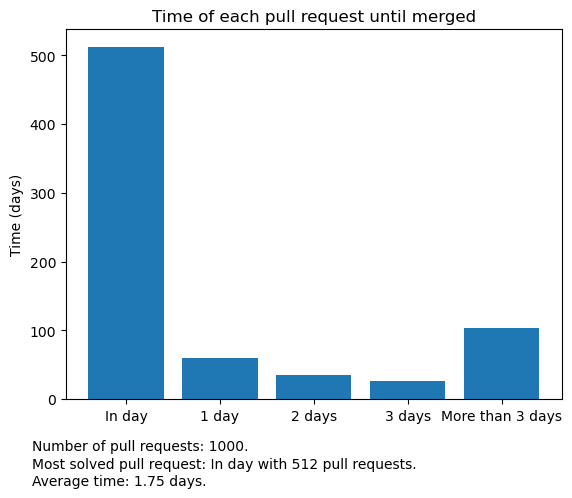

In [146]:

formatedPull['time'] = (formatedPull['merged_at'] - formatedPull['created_at']).dt.days
acceptedPull = formatedPull[formatedPull['merged'] == True]
timePull = pd.DataFrame()
timePull.index = ['In day', '1 day', '2 days', '3 days', 'More than 3 days']
timePull['time'] = [0, 0, 0, 0, 0]
timePull['time'][0] = acceptedPull[acceptedPull['time'] == 0]['time'].count() 
timePull['time'][1] = acceptedPull[acceptedPull['time'] == 1]['time'].count()
timePull['time'][2] = acceptedPull[acceptedPull['time'] == 2]['time'].count()
timePull['time'][3] = acceptedPull[acceptedPull['time'] == 3]['time'].count()
timePull['time'][4] = acceptedPull[acceptedPull['time'] > 3]['time'].count()
plt.subplot().bar(x = timePull.index, height = timePull['time'])
plt.ylabel('Time (days)')
plt.title('Time of each pull request until merged')
plt.text(-1, -75, f'Number of pull requests: {len(formatedPull)}.')
plt.text(-1, -100, f'Most solved pull request: {timePull["time"].idxmax()} with {timePull["time"].max()} pull requests.')
plt.text(-1, -125, f'Average time: {acceptedPull["time"].mean():.2f} days.')
formatedPull.to_csv('Data/Pull/finalFile.csv', index = False)



## Languages

### Data Cleaning & Processing

### Languages

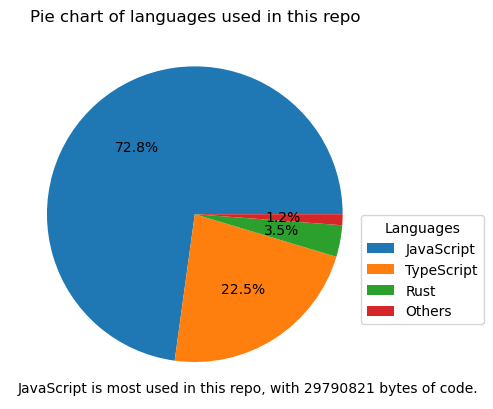

In [147]:
formatedLang = pd.read_json("Raw/Languages/raw.txt",  typ='series')
formatedLang.to_csv("Data/Languages/finalFile.csv")
pieLang = formatedLang[:3]
pieLang['Others'] = formatedLang[3:].sum()
plt.pie(pieLang.values, autopct='%1.1f%%')
plt.subplot().legend(
    labels = pieLang.index,
    title='Languages',
    loc = 'center right',
    bbox_to_anchor = (1, 0, 0.3, 0.7)
)
plt.title("Pie chart of languages used in this repo")
plt.text(-1.2, -1.2, f'{formatedLang.idxmax()} is most used in this repo, with {formatedLang.max()} bytes of code.')
plt.show()

## Contents

### Data Cleaning & Processing

In [148]:
formatedCon = pd.read_json("Raw/Content/raw.txt")

/tmp/ipykernel_4724/1918917832.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  fileSize['size'][0] = formatedCon[formatedCon['size'] == 0]['size'].count()
/tmp/ipykernel_4724/1918917832.py:8: FutureWarning: Series.__setitem__ treating ke

Text(-1.2, -1.2, 'pnpm-lock.yaml is the biggest file with 911833 bytes.')

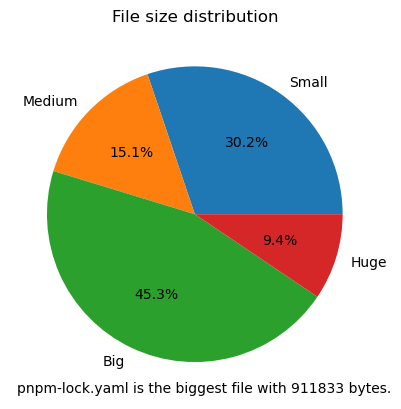

In [149]:
formatedCon = formatedCon.filter(['name', 'size'])
formatedCon.to_csv('Data/Content/clearedFile.csv')
formatedCon.set_index('name', inplace = True)
formatedCon.sort_values(by = 'size', ascending = False).head(10)
fileSize = pd.DataFrame()
fileSize.index = ['Small', 'Medium', 'Big', 'Huge']
fileSize['size'] = [0, 0, 0, 0]
fileSize['size'][0] = formatedCon[formatedCon['size'] == 0]['size'].count()
fileSize['size'][1] = formatedCon[(formatedCon['size'] <= 100) & (formatedCon['size'] > 0)]['size'].count()
fileSize['size'][2] = formatedCon[(formatedCon['size'] <= 10000) & (formatedCon['size'] > 100)]['size'].count()
fileSize['size'][3] = formatedCon[formatedCon['size'] > 10000]['size'].count()
plt.pie(fileSize['size'], labels=fileSize.index, autopct='%1.1f%%')
plt.title("File size distribution")
plt.text(-1.2, -1.2, f'{formatedCon["size"].idxmax()} is the biggest file with {formatedCon["size"].max()} bytes.')


## Growth

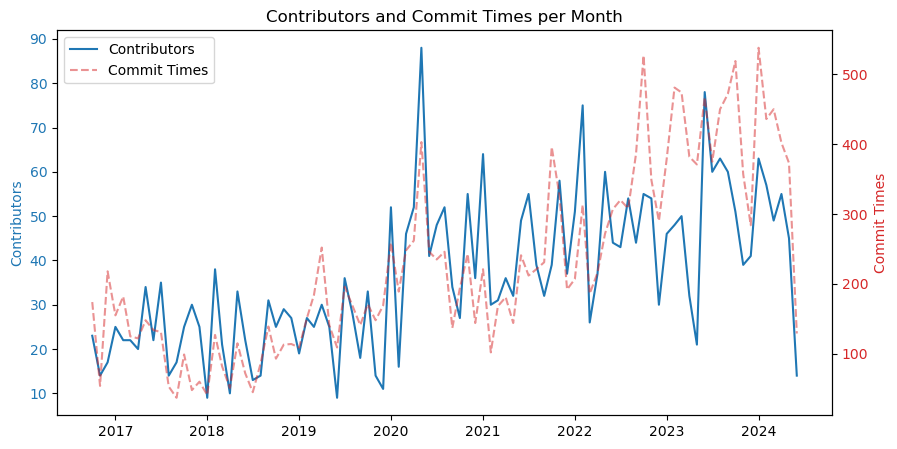

In [150]:
dateCommit = formatedCommit.copy()
dateCommit['committer.month'] = dateCommit['committer.date'].apply(lambda x: x.strftime('%Y-%m')) 
dateCommit = dateCommit['committer.month'].groupby(pd.to_datetime(dateCommit['committer.month'])).count()
dateContri = formatedCommit.copy()
dateContri['name'] = dateContri.index
dateContri.reset_index(inplace = True)
dateContri['month'] = dateContri['committer.date'].apply(lambda x: x.strftime('%Y-%m'))
dateContri = dateContri[['name', 'month']]
dateContri1 = dateContri.drop_duplicates(keep='first')
dateContri = dateContri.drop_duplicates('name', keep='first')
dateContri = dateContri.groupby(pd.to_datetime(dateContri['month'])).count()['month']
figure, ax1 = plt.subplots(figsize=(10, 5))

ax2 = ax1.twinx()

l1, = ax1.plot(dateContri.index, dateContri.values, markersize=15, label='Contributor Times')
ax1.set_ylabel('Contributors', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

l2, = ax2.plot(dateCommit.index, dateCommit.values, markersize=15, label='Commit Times', color='tab:red', alpha = 0.5, linestyle='dashed')
ax2.set_ylabel('Commit Times', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Contributors and Commit Times per Month')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.legend((l1, l2), ('Contributors', 'Commit Times'), loc = 'upper left')
plt.show()

dateContri.index = dateContri.index.strftime('%Y-%m')
dateCommit.index = dateCommit.index.strftime('%Y-%m')
final = pd.DataFrame({'Contributors': dateContri, 'Commit Times': dateCommit})
final.to_csv('Data/Growth/perMonth.csv')

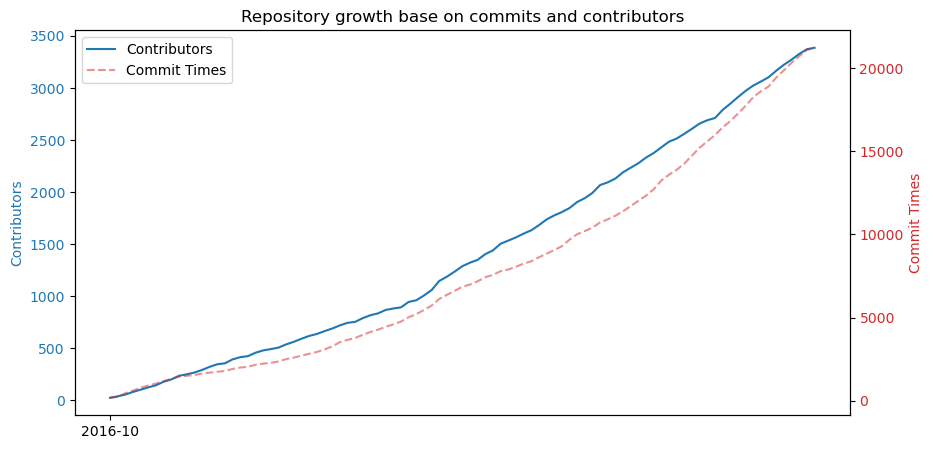

In [151]:
dateCommit = dateCommit.cumsum()
dateContri = dateContri.cumsum()

figure, ax1 = plt.subplots(figsize=(10, 5))

ax2 = ax1.twinx()

l1, = ax1.plot(dateContri.index, dateContri.values, markersize=15, label='Contributor Times')
ax1.set_ylabel('Contributors', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

l2, = ax2.plot(dateCommit.index, dateCommit.values, markersize=15, label='Commit Times', color='tab:red', alpha = 0.5, linestyle='dashed')
ax2.set_ylabel('Commit Times', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
plt.title('Repository growth base on commits and contributors')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.legend((l1, l2), ('Contributors', 'Commit Times'), loc = 'upper left')
plt.show()

final = pd.DataFrame({'Contributors': dateContri, 'Commit Times': dateCommit})
final.to_csv('Data/Growth/allTime.csv')

## Collaboration

In [161]:
raw = pd.read_json("Raw/Collaboration/raw.txt") 
test = pd.json_normalize(raw.user)
test = test[['login', 'id']]
test['body'] = raw.body
test.to_csv('Data/Collaboration/clearedFile.csv')

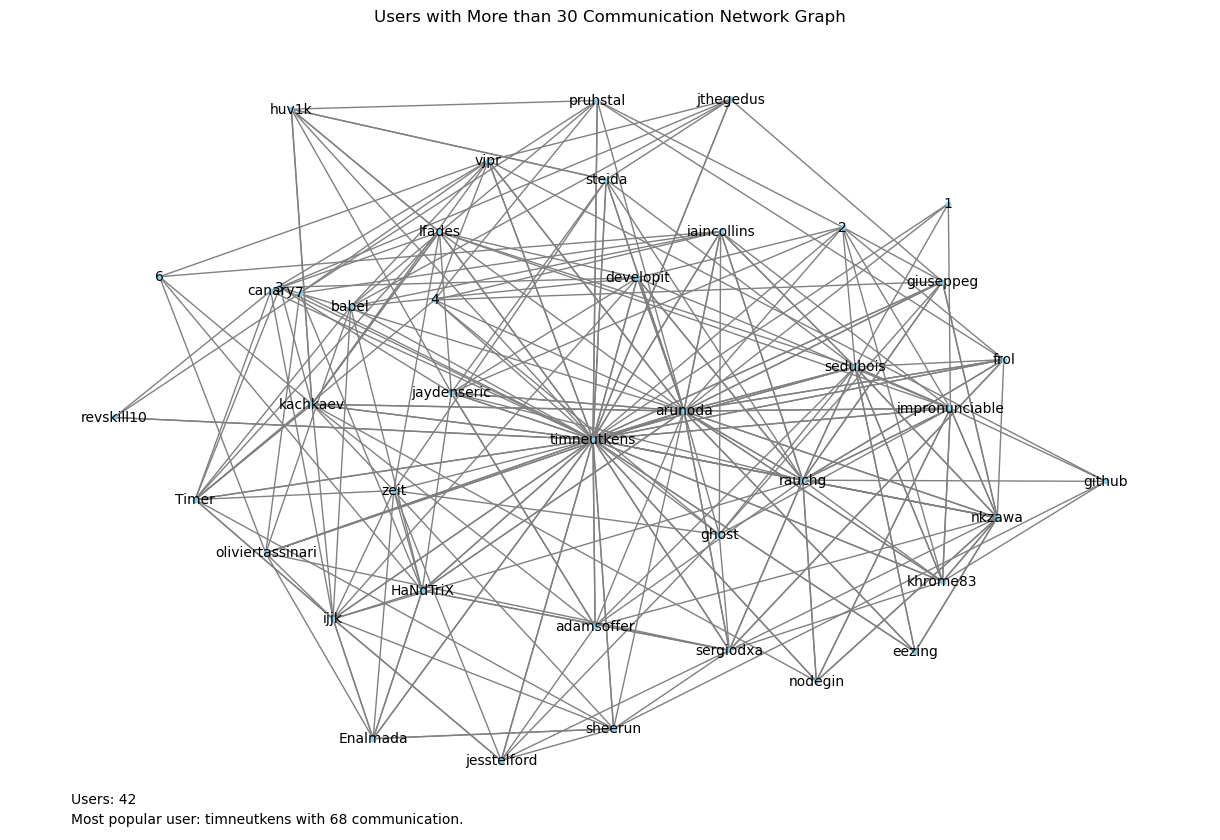

In [162]:
def extract(text):
    return re.findall(r'@(\w+)', text)
names = test['body'].apply(extract).explode().drop_duplicates().reset_index(drop=True)
edges = []
for _, row in test.iterrows():
    login = row['login']
    body = row['body']
    mentioned = extract(body)
    for user in mentioned:
        if user != login: 
            edges.append((login, user))
G = nx.DiGraph()
nodes = list(set(test['login'].tolist() + names.tolist()))  
G.add_nodes_from(nodes)
G.add_edges_from(edges)
lessPopular = [node for node in G.nodes() if G.degree(node) < 30]
G.remove_nodes_from(lessPopular)
plt.figure(figsize=(12, 8))
nx.draw(G, nx.kamada_kawai_layout(G), with_labels=True, node_color='skyblue', node_size=10, edge_color='gray', linewidths=1, arrowstyle='-', font_size=10)
plt.title('Users with More than 30 Communication Network Graph')
plt.text(-1, -1, f'Users: {len(G.nodes())}')
mostPopular = 0
mostPopularUser = ''
for node in G.nodes():
    if G.degree(node) > mostPopular:
        mostPopular = G.degree(node)
        mostPopularUser = node
plt.text(-1, -1.05, f'Most popular user: {mostPopularUser} with {mostPopular} communication.')
plt.show()

final = pd.DataFrame()
final['node'] = G.nodes()
final['times'] = [G.degree(node) for node in G.nodes()]
final = final.sort_values(by = 'times', ascending = False)
final.to_csv('Data/Collaboration/finalFile.csv')